# Installing Dependices

In [1]:
!pip install datasets
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 54.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.2 MB/s eta 0:00:00


In [2]:
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 5.8 MB/s eta 0:00:00


In [3]:
!pip install accelerate -U

In [4]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=995475a44895c9d9d41269ada25f6392bc6254dee8fba8da74c4f3ad62b6d8ed
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


# Importing Dependices

In [9]:
import datasets
import transformers
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from pathlib import Path

In [10]:
from tokenizers import ByteLevelBPETokenizer
from transformers import BertConfig, BertForMaskedLM
from transformers import BertTokenizerFast
from transformers import RobertaTokenizerFast

In [11]:
from transformers import VisionEncoderDecoderModel

In [12]:
from transformers import Seq2SeqTrainer
from transformers import Seq2SeqTrainingArguments
from transformers import Trainer, TrainingArguments

In [13]:
import transformers
import accelerate

print(transformers.__version__)
print(accelerate.__version__)


4.30.2
0.20.3


In [14]:
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


# Get the Data

In [15]:
%%bash
mkdir ~/.kaggle
cp kaggle.json ~/.kaggle/kaggle.json
chmod 600 ~/.kaggle/kaggle.json
pip install kaggle
kaggle datasets download -d adityajn105/flickr8k
unzip flickr8k.zip -d data


Archive:  flickr8k.zip
  inflating: data/Images/1000268201_693b08cb0e.jpg  
  inflating: data/Images/1001773457_577c3a7d70.jpg  
  inflating: data/Images/1002674143_1b742ab4b8.jpg  
  inflating: data/Images/1003163366_44323f5815.jpg  
  inflating: data/Images/1007129816_e794419615.jpg  
  inflating: data/Images/1007320043_627395c3d8.jpg  
  inflating: data/Images/1009434119_febe49276a.jpg  
  inflating: data/Images/1012212859_01547e3f17.jpg  
  inflating: data/Images/1015118661_980735411b.jpg  
  inflating: data/Images/1015584366_dfcec3c85a.jpg  
  inflating: data/Images/101654506_8eb26cfb60.jpg  
  inflating: data/Images/101669240_b2d3e7f17b.jpg  
  inflating: data/Images/1016887272_03199f49c4.jpg  
  inflating: data/Images/1019077836_6fc9b15408.jpg  
  inflating: data/Images/1019604187_d087bf9a5f.jpg  
  inflating: data/Images/1020651753_06077ec457.jpg  
  inflating: data/Images/1022454332_6af2c1449a.jpg  
  inflating: data/Images/1022454428_b6b660a67b.jpg  
  inflating: data/Images

# Preparing the Dataset

In [16]:
import os
import json


with open('data.json', 'r') as openfile:

    json_object = json.load(openfile)

images_caption_dict = dict(json_object)


images_path = '/content/data/Images/'
images = list(images_caption_dict.keys())

for image_path in images:
    if image_path.endswith('jpg'):
        new = images_path + image_path.split('/')[-1]
        images_caption_dict[new] = images_caption_dict.pop(image_path)
    else:
        images_caption_dict.pop(image_path)

In [17]:
import pandas as pd

df = pd.DataFrame([])

captions = []
images = []
for image in list(images_caption_dict.keys()):
    caption = images_caption_dict[image]
#     captions.append(('.'.join([ sent.rstrip() for sent in ('.'.join(caption)).split('<e>.<s>')]))\
#                             .replace('<s> ','').replace('  <e>','.'))
    for capt in caption:
        captions.append(capt.replace('<s> ','').replace('  <e>','').strip())
        images.append(image)

df['images'] = images
df['captions'] = captions

In [18]:
df.head()

,images,captions
0,/content/data/Images/1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set o...
1,/content/data/Images/1000268201_693b08cb0e.jpg,a girl going into a wooden building
2,/content/data/Images/1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse
3,/content/data/Images/1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playh...
4,/content/data/Images/1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a woo...


# Hyperparameters

In [19]:
TRAIN_BATCH_SIZE = 20   # input batch size for training (default: 64)
VALID_BATCH_SIZE = 5   # input batch size for testing (default: 1000)
VAL_EPOCHS = 1
LEARNING_RATE = 1e-4    # learning rate (default: 0.01)
SEED = 42               # random seed (default: 42)
MAX_LEN = 128           # Max length for product description
SUMMARY_LEN = 20         # Max length for product names

TRAIN_EPOCHS = 20     # number of epochs to train (default: 10)
WEIGHT_DECAY = 0.01
SEED = 42               # random seed (default: 42)
MAX_LEN = 128
SUMMARY_LEN = 20

# BERT Decoder

In [20]:
os.mkdir("./text_split")
def column_to_files(column, prefix, txt_files_dir = "./text_split"):
    # The prefix is a unique ID to avoid to overwrite a text file
    i=prefix
    #For every value in the df, with just one column
    for row in column.to_list():
      # Create the filename using the prefix ID
        file_name = os.path.join(txt_files_dir, str(i)+'.txt')
        try:
            # Create the file and write the column text to it
            f = open(file_name, 'wb')
            f.write(row.encode('utf-8'))
            f.close()
        except Exception as e:  #catch exceptions(for eg. empty rows)
            print(row, e)
        i+=1
    # Return the last ID
    return i

data = df["captions"]
# Removing the end of line character \n
data = data.replace("\n"," ")
# Set the ID to 0
prefix=0
# Create a file for every description value
prefix = column_to_files(data, prefix)

In [21]:
%%time
paths = [str(x) for x in Path(".").glob("text_split/*.txt")]

# Initialize a tokenizer
tokenizer = ByteLevelBPETokenizer(lowercase=True)

# Customize training
tokenizer.train(files=paths, vocab_size=10000, min_frequency=2,
                show_progress=True,
                special_tokens=[
                                "<s>",
                                "<pad>",
                                "<e>",
                                "<unk>",
                                "<mask>",
])

CPU times: user 2.11 s, sys: 774 ms, total: 2.88 s
Wall time: 3.98 s


In [ ]:
os.mkdir('Byte_tokenizer')
tokenizer.save_model('Byte_tokenizer')
tokenizer.save('/content/Byte.json')

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
FileExistsError: [Errno 17] File exists: 'Byte_tokenizer'

In [ ]:
config = BertConfig(
    vocab_size=10000,
    max_position_embeddings=514,
    num_attention_heads=12,
    num_hidden_layers=6,
    type_vocab_size=1,
)

model = BertForMaskedLM(config=config)

print('Num parameters: ',model.num_parameters())

# Create the tokenizer from a trained one
tokenizer = RobertaTokenizerFast.from_pretrained('Byte_tokenizer', max_len=MAX_LEN)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Num parameters:  51206416


In [22]:
class CustomDataset(Dataset):
    def __init__(self, df, tokenizer):
        # or use the RobertaTokenizer from `transformers` directly.

        self.examples = []

        for example in df.values:
            x=tokenizer.encode_plus(example, max_length = MAX_LEN, truncation=True, padding=True)
            self.examples += [x.input_ids]

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, i):
        # We’ll pad at the batch level.
        return torch.tensor(self.examples[i])

In [ ]:
train_dataset = CustomDataset(df['captions'][:38000], tokenizer)
test_dataset = CustomDataset(df['captions'][38000:], tokenizer)

In [ ]:
from transformers import DataCollatorForLanguageModeling

# Define the Data Collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

# Training the Decoder

In [ ]:
model_folder = "RobertMLM"
# Define the training arguments
training_args = TrainingArguments(
    output_dir=model_folder,
    overwrite_output_dir=True,
    evaluation_strategy = 'epoch',
    num_train_epochs=TRAIN_EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    per_device_train_batch_size=TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=VALID_BATCH_SIZE,
    save_steps=8192,
    #eval_steps=4096,
    save_total_limit=1,
)
# Create the trainer for our model
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    #prediction_loss_only=True,
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,3.247400,3.216526
2,3.038900,3.112914
3,2.884800,2.869812
4,2.725300,2.724309
5,2.603800,2.685187
6,2.494400,nan
7,2.428400,2.483862
8,2.321200,2.378862
9,2.239900,2.438993
10,2.186400,2.289080


TrainOutput(global_step=38000, training_loss=2.287040442215769, metrics={'train_runtime': 2458.383, 'train_samples_per_second': 309.146, 'train_steps_per_second': 15.457, 'total_flos': 4287783840698880.0, 'train_loss': 2.287040442215769, 'epoch': 20.0})

In [ ]:
import math
eval_results = trainer.evaluate()

print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

Perplexity: 8.40


In [ ]:
tokenizer.save_pretrained('Byte_tokenizer')

('Byte_tokenizer/tokenizer_config.json',
 'Byte_tokenizer/special_tokens_map.json',
 'Byte_tokenizer/vocab.json',
 'Byte_tokenizer/merges.txt',
 'Byte_tokenizer/added_tokens.json',
 'Byte_tokenizer/tokenizer.json')

In [ ]:
trainer.save_model(model_folder)

# Evaluating Decoder

In [ ]:
from transformers import pipeline

In [ ]:
fill_mask=pipeline(
    "fill-mask",
    model=r'RobertMLM',
    tokenizer="Byte_tokenizer"
)

In [ ]:
fill_mask("the boy is playing with a <mask>")

[{'score': 0.24037806689739227,
  'token': 433,
  'token_str': ' ball',
  'sequence': 'the boy is playing with a ball'},
 {'score': 0.1103123277425766,
  'token': 617,
  'token_str': ' toy',
  'sequence': 'the boy is playing with a toy'},
 {'score': 0.07027975469827652,
  'token': 636,
  'token_str': ' stick',
  'sequence': 'the boy is playing with a stick'},
 {'score': 0.05766482651233673,
  'token': 664,
  'token_str': ' football',
  'sequence': 'the boy is playing with a football'},
 {'score': 0.04434552043676376,
  'token': 756,
  'token_str': ' basketball',
  'sequence': 'the boy is playing with a basketball'}]

In [ ]:
!zip -r RobertMLM.zip RobertMLM/

  adding: RobertMLM/ (stored 0%)
  adding: RobertMLM/config.json (deflated 47%)
  adding: RobertMLM/training_args.bin (deflated 48%)
  adding: RobertMLM/checkpoint-32768/ (stored 0%)
  adding: RobertMLM/checkpoint-32768/trainer_state.json (deflated 83%)
  adding: RobertMLM/checkpoint-32768/config.json (deflated 47%)
  adding: RobertMLM/checkpoint-32768/training_args.bin (deflated 48%)
  adding: RobertMLM/checkpoint-32768/scheduler.pt (deflated 49%)
  adding: RobertMLM/checkpoint-32768/rng_state.pth (deflated 28%)
  adding: RobertMLM/checkpoint-32768/optimizer.pt (deflated 10%)
  adding: RobertMLM/checkpoint-32768/pytorch_model.bin (deflated 7%)
  adding: RobertMLM/checkpoint-32768/generation_config.json (deflated 8%)
  adding: RobertMLM/pytorch_model.bin (deflated 7%)
  adding: RobertMLM/generation_config.json (deflated 8%)
  adding: RobertMLM/runs/ (stored 0%)
  adding: RobertMLM/runs/Jul11_03-19-40_7aff88cf8010/ (stored 0%)
  adding: RobertMLM/runs/Jul11_03-19-40_7aff88cf8010/events.

In [ ]:
!zip -r Byte.zip Byte_tokenizer/

  adding: Byte_tokenizer/ (stored 0%)
  adding: Byte_tokenizer/added_tokens.json (stored 0%)
  adding: Byte_tokenizer/special_tokens_map.json (deflated 85%)
  adding: Byte_tokenizer/merges.txt (deflated 59%)
  adding: Byte_tokenizer/tokenizer_config.json (deflated 81%)
  adding: Byte_tokenizer/vocab.json (deflated 60%)
  adding: Byte_tokenizer/tokenizer.json (deflated 74%)


# Train Test Split

In [23]:
import random
def train_test_split(data):
  images=data.keys()
  images_test=random.sample(images,int(0.3*len(images)))
  images_train=[img for img in images if img not in images_test]

  train_dict={
      img: data[img] for img in images_train
  }
  test_dict={
      img: data[img] for img in images_test
  }
  return train_dict,test_dict

In [24]:
train_data,test_data=train_test_split(images_caption_dict)

<ipython-input-23-b7df0e05e1ca>:4: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  images_test=random.sample(images,int(0.3*len(images)))


In [25]:
train_data

{'/content/data/Images/1000268201_693b08cb0e.jpg': ['<s> a child in a pink dress is climbing up a set of stairs in an entry way  <e>',
  '<s> a girl going into a wooden building  <e>',
  '<s> a little girl climbing into a wooden playhouse  <e>',
  '<s> a little girl climbing the stairs to her playhouse  <e>',
  '<s> a little girl in a pink dress going into a wooden cabin  <e>'],
 '/content/data/Images/1001773457_577c3a7d70.jpg': ['<s> a black dog and a spotted dog are fighting <e>',
  '<s> a black dog and a try colored dog playing with each other on the road  <e>',
  '<s> a black dog and a white dog with brown spots are staring at each other in the street  <e>',
  '<s> two dogs of different breeds looking at each other on the road  <e>',
  '<s> two dogs on pavement moving toward each other  <e>'],
 '/content/data/Images/1002674143_1b742ab4b8.jpg': ['<s> a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl  <e>',
  '<s> a little girl is sitting in f

In [26]:
def get_df(data):
  df=pd.DataFrame([])
  captions=[]
  images=[]
  for image in list(images_caption_dict.keys()):
    caption=images_caption_dict[image]
    for capt in caption:
            captions.append(' '.join(capt.replace('<s> ','').replace('  <e>','').strip().split(' ')[:30]))
            images.append(image)
  df['images']=images
  df['captions']=captions
  return df

In [27]:
train_df=get_df(train_data)
test_df=get_df(test_data)

# Creating Feature Extractor

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import zipfile

zip_path = '/content/drive/MyDrive/RobertMLM.zip'  # Path to the ZIP file in your Google Drive
extract_path = '/content/model'  # Path to the folder where you want to extract the data

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Data extraction complete.")

Data extraction complete.


In [8]:
!unzip Byte.zip

Archive:  Byte.zip
   creating: Byte_tokenizer/
 extracting: Byte_tokenizer/added_tokens.json  
  inflating: Byte_tokenizer/special_tokens_map.json  
  inflating: Byte_tokenizer/merges.txt  
  inflating: Byte_tokenizer/tokenizer_config.json  
  inflating: Byte_tokenizer/vocab.json  
  inflating: Byte_tokenizer/tokenizer.json  


In [28]:
from transformers import RobertaTokenizerFast
tokenizer = RobertaTokenizerFast.from_pretrained('Byte_tokenizer', max_len=MAX_LEN)

In [29]:
from transformers import ViTFeatureExtractor, ViTModel
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


# Creating Custom Dataset

In [30]:
from PIL import Image

In [31]:
class ImageCaptionDataset(Dataset):
  def __init__(self,df,tokenizer,feature_extractor,max_len=31):
    self.df=df
    self.tokenizer = tokenizer
    self.feature_extractor = feature_extractor
    self.max_length = max_len
  def __len__(self):
    return len(self.df)
  def __getitem__(self,idx):
    img_path = self.df['images'][idx]
    caption = self.df['captions'][idx]
    image = Image.open(img_path).convert("RGB")
    pixel_values = self.feature_extractor(image, return_tensors="pt").pixel_values
    labels = self.tokenizer(caption, truncation = True,
                                          padding="max_length",
                                          max_length=self.max_length).input_ids
    labels = [label if label != self.tokenizer.pad_token_id else -100 for label in labels]
    encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
    return encoding

In [32]:
train_dataset=ImageCaptionDataset(df=train_df.sample(frac=0.3,random_state=2).iloc[:10000].reset_index().drop('index',axis =1),
                           tokenizer=tokenizer,
                          feature_extractor= feature_extractor)
test_dataset=ImageCaptionDataset(df=test_df.sample(frac=0.1,random_state=2)[:2000].reset_index().drop('index',axis =1),
                           tokenizer=tokenizer,feature_extractor= feature_extractor)

# Evaluation Metrics

In [33]:
rouge = datasets.load_metric("rouge")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)
    rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid
    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }

<ipython-input-33-969bffe103e9>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = datasets.load_metric("rouge")


# Model Configuration

In [34]:
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained\
                    ("google/vit-base-patch16-224-in21k", 'model/RobertMLM', tie_encoder_decoder=True)

Some weights of BertLMHeadModel were not initialized from the model checkpoint at model/RobertMLM and are newly initialized: ['bert.encoder.layer.5.crossattention.self.value.weight', 'bert.encoder.layer.3.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.output.dense.bias', 'bert.encoder.layer.4.crossattention.self.key.bias', 'bert.encoder.layer.3.crossattention.output.dense.bias', 'bert.encoder.layer.3.crossattention.self.value.weight', 'bert.encoder.layer.1.crossattention.self.value.bias', 'bert.encoder.layer.4.crossattention.self.query.bias', 'bert.encoder.layer.1.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.encoder.layer.2.crossattention.self.key.weight', 'bert.encoder.layer.2.crossattention.self.key.bias', 'bert.encoder.layer.2.crossattention.self.value.weight', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.2.cro

In [35]:
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = tokenizer.sep_token_id
model.config.max_length = 20
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

# Training the Model

In [36]:
captioning_model = 'VIT_Captioning'

training_args = Seq2SeqTrainingArguments(
    output_dir=captioning_model,
    per_device_train_batch_size=TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=TRAIN_BATCH_SIZE,
    predict_with_generate=True,
    #evaluate_during_training=True,
    evaluation_strategy="epoch",
    do_train=True,
    do_eval=True,
    logging_steps=1024,
    save_steps=2048,
    warmup_steps=1024,
    #max_steps=1500, # delete for full training
    num_train_epochs = 10, #TRAIN_EPOCHS
    overwrite_output_dir=True,
    save_total_limit=1,
)

In [37]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    tokenizer=feature_extractor,
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=default_data_collator,
)


In [38]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Rouge2 Precision,Rouge2 Recall,Rouge2 Fmeasure
1,No log,2.687847,0.074100,0.079100,0.073900
2,No log,2.332145,0.107100,0.107000,0.103100
3,3.505700,2.062962,0.133800,0.141400,0.132900
4,3.505700,1.803856,0.166700,0.176000,0.165500
5,2.235800,1.597185,0.188800,0.205400,0.191700
6,2.235800,1.396585,0.220700,0.235400,0.222100
7,1.771200,1.234002,0.255200,0.271900,0.257600
8,1.771200,1.116550,0.286300,0.293100,0.283800
9,1.417500,1.032414,0.311200,0.318200,0.309000
10,1.417500,0.998663,0.320100,0.331800,0.320400


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1259: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(


TrainOutput(global_step=5000, training_loss=2.0463281982421875, metrics={'train_runtime': 7055.1531, 'train_samples_per_second': 14.174, 'train_steps_per_second': 0.709, 'total_flos': 1.29788464103424e+19, 'train_loss': 2.0463281982421875, 'epoch': 10.0})

In [41]:
trainer.save_model('Image_Captioning_VIT_BERT')

In [42]:
!zip -r Image_Captioning_VIT_BERT.zip Image_Captioning_VIT_BERT/

  adding: Image_Captioning_VIT_BERT/ (stored 0%)
  adding: Image_Captioning_VIT_BERT/config.json (deflated 78%)
  adding: Image_Captioning_VIT_BERT/training_args.bin (deflated 49%)
  adding: Image_Captioning_VIT_BERT/pytorch_model.bin (deflated 7%)
  adding: Image_Captioning_VIT_BERT/generation_config.json (deflated 33%)
  adding: Image_Captioning_VIT_BERT/preprocessor_config.json (deflated 46%)
	zip warning: name not matched: ViT_Captioning/

zip error: Nothing to do! (try: zip -r ViT_Encoder.zip . -i ViT_Captioning/)


In [47]:
!zip -r ViT_Encoder.zip VIT_Captioning/

  adding: VIT_Captioning/ (stored 0%)
  adding: VIT_Captioning/checkpoint-4096/ (stored 0%)
  adding: VIT_Captioning/checkpoint-4096/trainer_state.json (deflated 77%)
  adding: VIT_Captioning/checkpoint-4096/config.json (deflated 78%)
  adding: VIT_Captioning/checkpoint-4096/training_args.bin (deflated 49%)
  adding: VIT_Captioning/checkpoint-4096/scheduler.pt (deflated 48%)
  adding: VIT_Captioning/checkpoint-4096/rng_state.pth (deflated 28%)
  adding: VIT_Captioning/checkpoint-4096/optimizer.pt (deflated 9%)
  adding: VIT_Captioning/checkpoint-4096/pytorch_model.bin (deflated 7%)
  adding: VIT_Captioning/checkpoint-4096/generation_config.json (deflated 33%)
  adding: VIT_Captioning/checkpoint-4096/preprocessor_config.json (deflated 46%)
  adding: VIT_Captioning/runs/ (stored 0%)
  adding: VIT_Captioning/runs/Jul11_06-04-07_c28291f7f1e9/ (stored 0%)
  adding: VIT_Captioning/runs/Jul11_06-04-07_c28291f7f1e9/events.out.tfevents.1689055459.c28291f7f1e9.188.0 (deflated 68%)


In [40]:
t = VisionEncoderDecoderModel.from_pretrained('Image_Cationing_VIT_BERT')

The following encoder weights were not tied to the decoder ['vision_encoder_decoder/encoder', 'vision_encoder_decoder/pooler', 'vision_encoder_decoder/embeddings', 'vision_encoder_decoder/layernorm']
The following encoder weights were not tied to the decoder ['vision_encoder_decoder/encoder', 'vision_encoder_decoder/pooler', 'vision_encoder_decoder/embeddings', 'vision_encoder_decoder/layernorm']


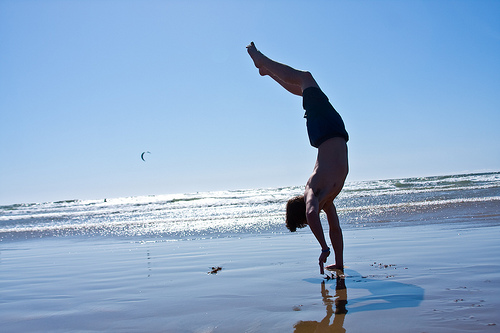

In [45]:
temp = test_df.sample(2).images.iloc[0]
Image.open(temp).convert("RGB")

In [46]:
tokenizer.decode(t.generate(feature_extractor(Image.open(temp).convert("RGB"), return_tensors="pt").pixel_values)[0])

'<s><s>a man is doing a handstand on the beach</s>'

In [50]:
!mv /content/Image_Captioning_VIT_BERT.zip /content/drive/MyDrive/

mv: cannot stat '/content/Image_Captioning_VIT_BERT.zip': No such file or directory


In [51]:
!mv /content/ViT_Encoder.zip /content/drive/MyDrive/